# Домашнее задание 8: Face Recognition

**Описание/Пошаговая инструкция выполнения домашнего задания:**

- Возьмите датасет Olivetti
- Получите эмбеддинги изображений с помощью преобразований PCA
- Обучите любую модель классификации

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, TQDMProgressBar
from sklearn.decomposition import PCA


from olivetti_lib import OlivettiDataModule, OlivettiDataSet, OlivettiModel

SEED = 2022

## 1 Подготовка данных

### 1.1 Описание датасета Olivetti

- Все изображения взяты между 1992 и 1994 годами
- 40 людей, 10 изображений каждого, всего 400 изображений
- Изображения были сняты в разное время, с разным освещением и с разным поворотом головы
- На всех изображениях черный задник
- Изображения нормализованы по высоте
- Размер изображения 64x64
- Значения пикселей изображений нормированы в диапазоне от 0 до 1
- Каждому человеку был присвоен номер от 0 до 39

In [2]:
data = np.load("olivetti_faces.npy")
target = np.load("olivetti_faces_target.npy")

In [3]:
print("Кол-во изображений: {}".format(len(data)))
print("Кол-во уникальных меток: {}".format(len(np.unique(target))))
print("Размер изображений: {}x{}".format(data.shape[1],data.shape[2]))

Кол-во изображений: 400
Кол-во уникальных меток: 40
Размер изображений: 64x64


In [4]:
def show_40_distinct_people(images):
    """ Печатает уникальных людей в датасете
    
    Параметры
    ---------
    images : np.ndarray
      Массив изображений датасета Olivetty.
      Надо передать исходный массив, в котором люди неотсортированы.
    """

    fig, axarr=plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
    axarr=axarr.flatten()
    
    # Всего 40 людей в датасете, у каждого человека 10 разных изображений
    for unique_id in range(40):
        # Берем самое первое изображение человека
        image_index=unique_id*10
        axarr[unique_id].imshow(images[image_index], cmap='gray')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{}".format(unique_id))
        
    plt.suptitle(f"40 уникальных людей в датасете")

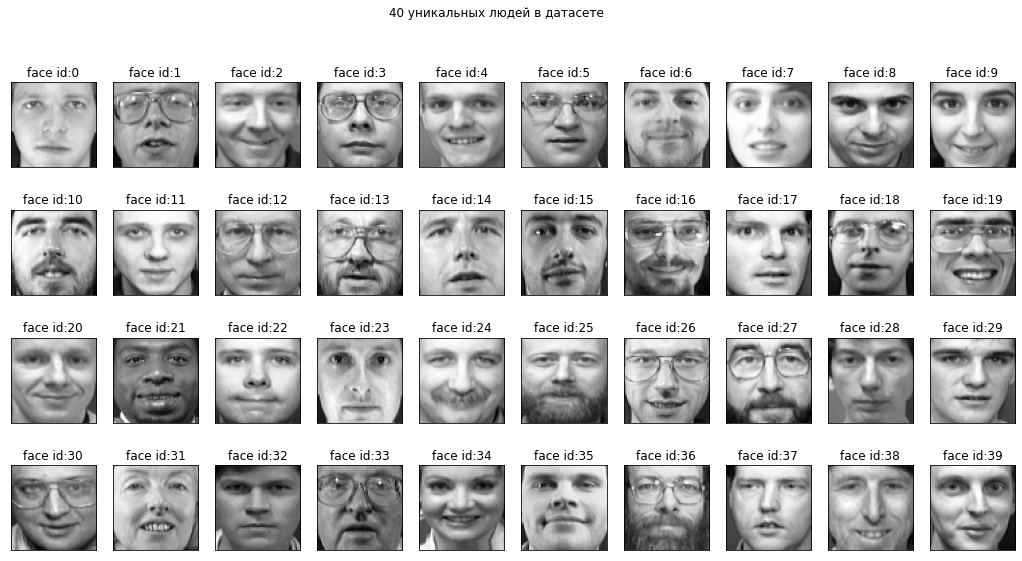

In [5]:
show_40_distinct_people(data)

### 1.2 Получение ембеддиногов лиц с помощью преобразования PCA

Для распознавания лиц можно использовать различные способы получения эмбеддингов изображений лиц. Один из вариантов формировать такие эмбеддинги - сжатие м помощью метода главных компонент PCA.

Для начала необходимо определиться, какой длины будет вектор эмбеддинга. В случае PCA размер вектора эмбеддинга - количество главных компонент. Построим график размера дисперсий для 100 главных компонент:

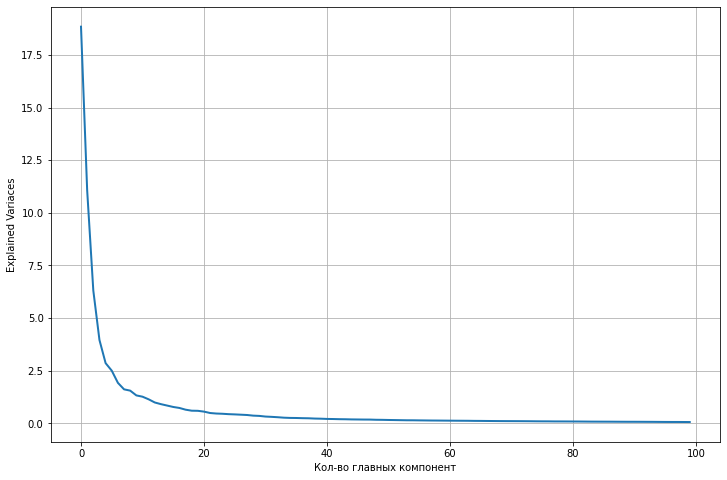

In [6]:
X=data.reshape([data.shape[0],-1])

pca=PCA(100)
pca.fit(X)

plt.figure(1, figsize=(12,8))

plt.plot(pca.explained_variance_, linewidth=2)
 
plt.xlabel('Кол-во главных компонент')
plt.ylabel('Explained Variaces')
plt.grid()

plt.show()

Из полученного графика видно, что примерно после 50 главной компоненты. Поэтому в качестве длин ембеддинга можно взять эту цифру.

Проверим процент описанной компонентами дисперсии:

In [7]:
n_components = 50

print("Кол-во компонент:", n_components)
print("Процент описанной компонентами дисперсии:", round(np.sum(pca.explained_variance_ratio_[:50])*100, 2))

Кол-во компонент: 50
Процент описанной компонентами дисперсии: 87.38


### 1.3 Подготовка датасета для входа модели

Для подготовки изображений для входа модели сделаны классы OlivettiDataSet и OlivettiDataModule.

OlivettiDataSet разбивает данные части для обучения и валидации, а также применяет к данным преобразование PCA. А класс OlivettiDataModule позволяет получить загрузчик данных на основе OlivettiDataSet.

Пример инициализации OlivettiDataModule:

```
datamodule = OlivettiDataModule(faces_npy='olivetti_faces.npy', target_npy='olivetti_faces_target.npy', test_size=0.2, embedding_size=50)
```

## 2 Обучение модели классификатора

В качестве классификатора возьмем полносвязную нейронную сеть, которая принимает на вход эмбеддинги изображений и на выходе дает логиты для каждого из 40 классов. Архитектура модели реализована в классе OlivettiModel. Модель состоит из 5 полносвязных слоев размером 512.

Составим конфигурацию для модели и обучим ее:

In [8]:
pca_n_components = 50

config = {'seed': SEED,
    'model': {
        'input_size': pca_n_components,
        'plot_epoch_loss': True,
        'dropout': 0.5,
        'learning_rate': 0.005, 
        'l2_regularization': 0.01,
        'adam_betas': (0.99, 0.999),
        'seed': SEED,
    },
    'trainer': {
        'max_epochs': 300,
        'gpus': 1 if torch.cuda.is_available() else 0,
        'resume_from_checkpoint': None,
    },
    'datamodule': {
        'seed': SEED,
        'faces_npy': 'olivetti_faces.npy',
        'target_npy': 'olivetti_faces_target.npy',
        'test_size': 0.3,
        'embedding_size': pca_n_components,
        'train_loader_params': {
            'batch_size': 64,
            'shuffle': True,
            'num_workers': 0,
            'pin_memory': False,
            'drop_last': True,
        },
        'val_loader_params': {
            'batch_size': 64,
            'shuffle': False,
            'num_workers': 0,
            'pin_memory': False,
            'drop_last': False
        },
    },
}

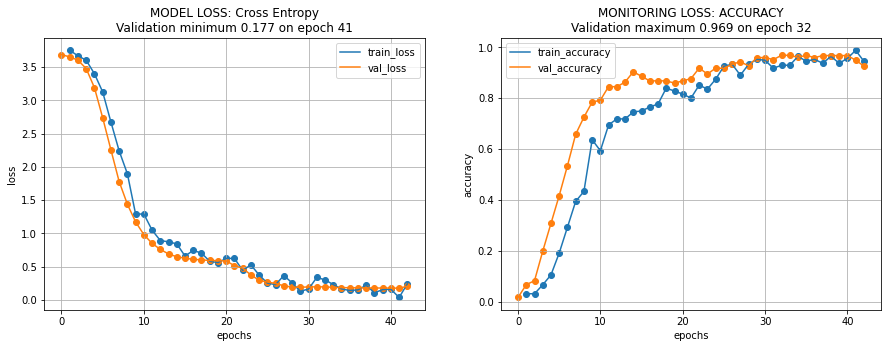

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = OlivettiModel(**config['model'])
olivetty_datamodule = OlivettiDataModule(**config['datamodule'])
checkpoint = ModelCheckpoint(dirpath='checkpoint_model/', monitor='val_accuracy', mode='max')

callbacks = [
            EarlyStopping('val_accuracy', min_delta=0.001, patience=10, mode='max'),
            TQDMProgressBar(refresh_rate=1),
            checkpoint
]

trainer = pl.Trainer(**config['trainer'], callbacks=callbacks)

trainer.fit(model, olivetty_datamodule)

model = OlivettiModel.load_from_checkpoint(checkpoint.best_model_path)
model = model.to(device)

torch.save(model.state_dict(), 'model_best.pth')

Удалось обучить модель до значения accuracy 0.969 на валидационной части датасета.

Визуализируем результаты предсказания модели для валидационной части:

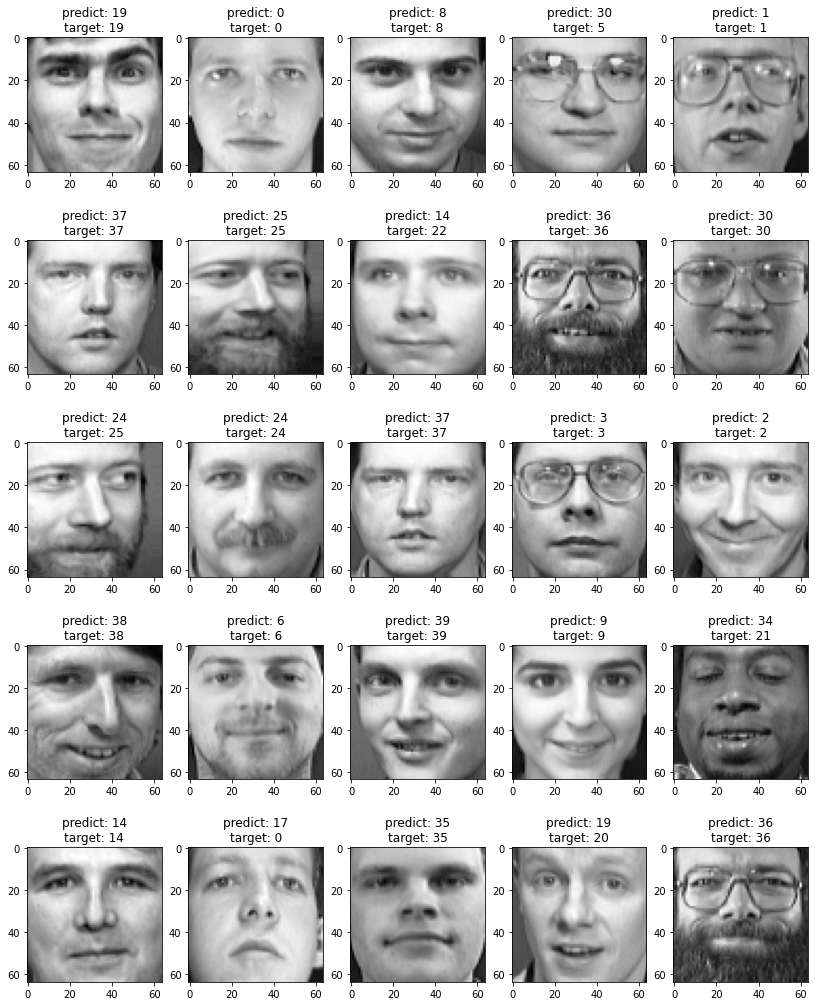

In [10]:
olivetty_datamodule.val_loader_params['batch_size'] = 1
olivetty_datamodule.val_loader_params['shuffle'] = True

_, axes = plt.subplots(5,5, figsize=(14,18))
axes = axes.flatten()
val_loader = olivetty_datamodule.val_dataloader()

for idx, batch in enumerate(val_loader):
    img = batch['img'][0][0]
    axes[idx].imshow(img, cmap='gray')
    
    prediction = model(batch['embedding'].to(device)).cpu().detach().numpy().flatten()
    pred_target = np.argmax(prediction)
    true_target = batch['label'][0].item()
    
    axes[idx].set_title(f"predict: {pred_target}\ntarget: {true_target}")
    
    if idx >= 24:
        break

# ИТОГИ

В данной работе были получены эмбеддинги лиц людей с помощью PCA и обучен классификатор на основе полносвязной нейронной сети. На валидационной части датасета удалось получить значение accuracy 0.969